In [1]:
%matplotlib ipympl 

#import sys
#sys.path.insert(1, '/project/f/fherwig/fherwig/PythonVirtual/NuGridPy')

import numpy as np
from matplotlib import pyplot as plt

from nugridpy import nugridse as nuse
from nugridpy import utils

import os
import sys
import contextlib
import pandas as pd

import h5py

from matplotlib import colors as mcolors
from matplotlib.ticker import MaxNLocator

from astropy import constants as const
from astropy import units as u

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

# important feature!
import load_mppnp

In [2]:
def get_sol_abu(isotopes):    

    def get_sol(sol_ab="/user/niagara_scratch_fherwig/wendi.user/jissa/mixing_results/iniab2.0E-02GN93.ppn"):
        '''
            grab the solar abundances and turn it into a dataframe
        '''
            
        f = open(sol_ab, 'r')
    
        sol_iso_z=[]
        sol_iso=[]
        sol_iso_name = []
        sol_iso_a = []
        sol_iso_abu=[]
    
        for line in f:
            n = len(line.split())
            if n == 3:
                sol_iso = line.split()[1]
                if sol_iso == 'PROT':
                    sol_iso_name.append('h')
                    sol_iso_a.append(1)
                    sol_iso_z.append(int(line.split()[0]))
                    sol_iso_abu.append(float(line.split()[2]))
                else:
                    sol_iso_name.append(sol_iso[0:2])
                    sol_iso_a.append(int(sol_iso[2:5]))
                    sol_iso_z.append(int(line.split()[0]))
                    sol_iso_abu.append(float(line.split()[2]))
            if n == 4:
                sol_iso_z.append(int(line.split()[0]))
                sol_iso_name.append(line.split()[1])
                sol_iso_a.append(int(line.split()[2]))
                sol_iso_abu.append(float(line.split()[3]))
    
        f.close()
    
        df_solar = pd.DataFrame()
        df_solar['Z'] = sol_iso_z
        df_solar['Element'] = sol_iso_name
        df_solar['sol_iso_a'] = sol_iso_a
        df_solar['sol_iso_abu'] = sol_iso_abu
        
        return df_solar

    df_solar = get_sol()
    
    if type(isotopes) == str:
        
        ele, num = isotopes.split('-')
        
        elemask = df_solar.Element == ele.lower()
                
        nummask = df_solar.sol_iso_a == int(num)
        
        mask = elemask & nummask
        
        abu = df_solar[mask].sol_iso_abu.to_numpy()[0]
        
        return abu
    
    else:
        res = []
        for iso in isotopes:
            ele, num = iso.split('-')
        
            elemask = df_solar.Element == ele.lower()

            nummask = df_solar.sol_iso_a == int(num)

            mask = elemask & nummask
            
            abu = df_solar[mask].sol_iso_abu.to_numpy()[0]
            res.append(abu)
            
        return np.array(res)

In [3]:
def get_everything_you_need(mixing_case, sub_case="7.95E+03"):
    # the initial abundances for NOVA models are the Asplund et al. (2009) solar abundances 
    upper = "/user/niagara_scratch_fherwig/wendi.user/jissa/mixing_results/"
    if mixing_case != "GOSH": mppnp_test_dir=upper + f"{mixing_case}_RUNS/hif{sub_case}/"
    else: mppnp_test_dir=upper + f"{mixing_case}_RUNS/{sub_case}/"
    
    sol_ab=upper+"iniab2.0E-02GN93.ppn"
    
    init_ab=sol_ab
    
    utils.solar(sol_ab,1.)
    sol_abu=utils.solar_elem_abund
    n_sol=len(sol_abu)

    # read in initial elemental abundances in the path init_ab
    utils.solar(init_ab,1.)
    init_abu=utils.solar_elem_abund
    n_init=len(init_abu)
    #print ("\nn_init =",n_init)

    # read in solar abundances in the path sol_ab
    utils.solar(sol_ab,1.)
    sol_abu=utils.solar_elem_abund
    n_sol=len(sol_abu)
    #print ("\nn_sol =",n_sol)
    
    # initial and solar abundances do not include Tc and Pm
    # here we include them with the abundances 1e-99
    
    n_el = n_sol + 2  # n_sol + the unstable Tc (Z=43) and Pm (Z=61)
    
    el_name=["  " for x in range(n_el)]
    
    z_el=np.linspace(0,0,n_el)
    
    el_name[0]='n'
    for i in range(n_el):
        z_el[i]=float(i)       #  Z=i in mppnp surf data output
        if (i>0):
            el_name[i]=utils.get_el_from_z(i)
    
    # el_abu_init = np.linspace(1e-99,1e-99,n_el)
    el_abu_sol = np.linspace(1e-99,1e-99,n_el)
    
    for i in range(n_el):  
        for k in range(n_sol):
            z_sol=k+1
            if float(z_sol)==z_el[i] and z_sol != 43 and z_sol != 61:  
    #             el_abu_init[i] = init_abu[k]
                el_abu_sol[i] = sol_abu[k]
    
    # print ("X_init =",el_abu_init[1],", X_init(Tc) =", el_abu_init[43],", X_init(Pm) =", el_abu_init[61])
    #print ("X_sol =",el_abu_sol[1],", X_sol(Tc) =", el_abu_sol[43],", X_sol(Pm) =", el_abu_sol[61])

    work_dir = mppnp_test_dir

    model = 11200
    
    mc = 0 
    h5_file = work_dir + "my_test_hif.0010001.surf.h5"
    
    #print("Zero variation case:", h5_file)
    with h5py.File(h5_file, 'r') as file:
        dset = file["/cycle"+str(model).zfill(10)+"/SE_DATASET"]
        el_abu_0 = dset['elem_massf_decay'][0]
        iso_abu_0 = dset['iso_massf_decay'][0]

    
        n_iso = len(iso_abu_0)
        iso_z=np.linspace(0,0,n_iso)
        iso_a=np.linspace(0,0,n_iso)
        iso_name=["  " for x in range(n_iso)]

        iso_name[0] = 'n'
        iso_name[1] = 'H'
        
        dseta = file["A"]
        dsetz = file["Z"]
        iso_a[:] = dseta[:]
        iso_z[:] = dsetz[:]

    
    isomers = ['ALm', 'KRm', 'CDm', 'LUm', 'TAm']
    start = n_iso - len(isomers)
    for isomer in isomers: 
        i = isomers.index(isomer)
        iso_name[start+i] = isomer
    
    for i in range(2,n_iso-len(isomers)):
        iz = int(iso_z[i])
        iso_name[i] = utils.get_el_from_z(int(iso_z[i]))
        
    iso_full_name = []
    for i in range(n_iso):
        iso_full_name.append(iso_name[i]+"-"+str(int(iso_a[i])))
    
    return el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_full_name

In [4]:
el_abu_0, el_abu_sol, el_name, iso_abu_0, iso_name = get_everything_you_need("MLT")

This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files


In [5]:
star = nuse.se("/data/nugrid/data/set1ext/set1.2/ppd_wind/M15.0Z2.0e-02/H5_out")

Searching files, please wait.......
Reading preprocessor files
File search complete.


In [6]:
upper = "/user/niagara_scratch_fherwig/wendi.user/jissa/mixing_results/"

MLT = load_mppnp.mppnpAnalysis(upper+"MLT_RUNS/hif7.95E+03",
                               upper+"iniab2.0E-02GN93.ppn",
                               upper+"MLT_RUNS/flux_run/fluxes_fixed",
                               upper+"MLT_RUNS/flux_run/networksetup.txt",
                               upper+"cshell_abund2.ppn")

Reading in data for cycle block 0010001. This may take a while.
Searching files, please wait.......
Writing preprocessor files
my_test_hif.0010001.out.h5
Reading the solar abundance information.


Exception in thread Thread-25:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/h5T.py", line 458, in run
    write(self.preprocName,header,dcols,data,sldir=self.filename)
  File "/usr/local/lib/python3.6/dist-packages/nugridpy/ascii_table.py", line 480, in write
    tmp1=data_fmt.format(data[i][j])
ValueError: Unknown format code 'f' for object of type 'str'



Reading in the cross-section information.
Processed 0/404 files
Processed 50/404 files
Processed 100/404 files
Processed 150/404 files
Processed 200/404 files
Processed 250/404 files
Processed 300/404 files
Processed 350/404 files
Processed 400/404 files


In [7]:
cycle = 9200

isos = ["Hg-196"]

params = ['mass', 'dcoeff'] + isos
loaded = {param: star.get(cycle, param) for param in params}

idxs = [iso_name.index(iso) for iso in isos]
my_Xs = iso_abu_0[idxs]

 reading ['iso_massf']...100%

 reading ['iso_massf']...100%

(3.8433534134926377e-07, 12.15340998801299)

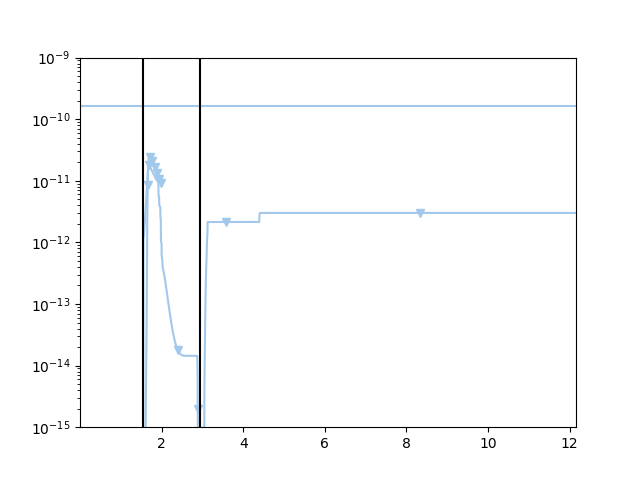

In [8]:
ifig=1;plt.close(ifig);plt.figure(ifig)

for i, X in enumerate(my_Xs):
    plt.axhline(X, ls=utils.linestylecb(i)[0],color=utils.linestylecb(i)[2])

my_mass = MLT.grab('out', 11000, 'mass').value
for i, iso in enumerate(isos):
    X = MLT.grab('out', 11000, iso)
    plt.semilogy(my_mass, X, marker=utils.linestylecb(i)[1],color=utils.linestylecb(i)[2], markevery=50)
    
    
for i, iso in enumerate(isos):    
    plt.semilogy(loaded["mass"], loaded[iso], ls=utils.linestylecb(i)[0], marker=utils.linestylecb(i)[1],color=utils.linestylecb(i)[2], markevery=600)

    
#plt.plot(loaded["mass"], np.log10(loaded["dcoeff"])/25, color='black',zorder=1, alpha=0.1)

plt.ylim(1e-15, 1e-9)

plt.axvline(1.55, color='black')
plt.axvline(2.95, color='black')

plt.xlim(loaded["mass"][0], loaded["mass"][-1])

### Is there a way to choose the stuff in black to be my stuff and not the NuGrid stuff?
Naive approach:
$$
X_f = \frac{1}{12}\int_0^{1.55} X_{\mathrm{NuGrid}}(m) dm + \frac{2.95-1.55}{12} X_{\mathrm{me}} + \frac{1}{12} \int_{2.95}^{12} X_{\mathrm{NuGrid}}(m) dm
$$

In [9]:
all_stable_species = ['H-1', 'H-2', 'He-3', 'He-4', 'Li-7','B-11',
                      'C-12', 'C-13', 'N-14', 'N-15', 'O-16', 'O-17', 'O-18', 'F-19', 'Ne-20', 'Ne-21', 'Ne-22',
                      'Na-23', 'Mg-24', 'Mg-25', 'Mg-26', 'Al-27', 'Si-28', 'Si-29', 'Si-30', 'P-31', 'S-32', 'S-33',
                      'S-34', 'S-36', 'Cl-35', 'Cl-37', 'Ar-36', 'Ar-38', 'Ar-40', 'K-39', 'K-40', 'K-41', 'Ca-40',
                      'Ca-42', 'Ca-43', 'Ca-44', 'Ca-46', 'Ca-48', 'Sc-45', 'Ti-46', 'Ti-47', 'Ti-48', 'Ti-49', 'Ti-50',
                      'V-50', 'V-51', 'Cr-50', 'Cr-52', 'Cr-53', 'Cr-54', 'Mn-55', 'Fe-54', 'Fe-56', 'Fe-57', 'Fe-58',
                      'Co-59', 'Ni-58', 'Ni-60', 'Ni-61', 'Ni-62', 'Ni-64', 'Cu-63', 'Cu-65', 'Zn-64', 'Zn-66', 'Zn-67',
                      'Zn-68', 'Zn-70', 'Ga-69', 'Ga-71', 'Ge-70', 'Ge-72', 'Ge-73', 'Ge-74', 'Ge-76', 'As-75', 'Se-74',
                      'Se-76', 'Se-77', 'Se-78', 'Se-80', 'Se-82', 'Br-79', 'Br-81', 'Kr-78', 'Kr-80', 'Kr-82', 'Kr-83',
                      'Kr-84', 'Kr-86', 'Rb-85', 'Rb-87', 'Sr-84', 'Sr-86', 'Sr-87', 'Sr-88', 'Y-89', 'Zr-90', 'Zr-91',
                      'Zr-92', 'Zr-94', 'Zr-96', 'Nb-93', 'Mo-92', 'Mo-94', 'Mo-95', 'Mo-96', 'Mo-97', 'Mo-98', 'Mo-100',
                      'Ru-96', 'Ru-98', 'Ru-99', 'Ru-100', 'Ru-101', 'Ru-102', 'Ru-104', 'Rh-103', 'Pd-102',
                      'Pd-104', 'Pd-105', 'Pd-106', 'Pd-108', 'Pd-110', 'Ag-107', 'Ag-109', 'Cd-106', 'Cd-108', 'Cd-110',
                      'Cd-111', 'Cd-112', 'Cd-113', 'Cd-114', 'Cd-116', 'In-113', 'In-115', 'Sn-112', 'Sn-114', 'Sn-115',
                      'Sn-116', 'Sn-117', 'Sn-118', 'Sn-119', 'Sn-120', 'Sn-122', 'Sn-124', 'Sb-121', 'Sb-123', 'Te-120',
                      'Te-122', 'Te-123', 'Te-124', 'Te-125', 'Te-126', 'Te-128', 'Te-130', 'I-127', 'Xe-124', 'Xe-126',
                      'Xe-128', 'Xe-129', 'Xe-130', 'Xe-131', 'Xe-132', 'Xe-134', 'Xe-136', 'Cs-133', 'Ba-130', 'Ba-132',
                      'Ba-134', 'Ba-135', 'Ba-136', 'Ba-137', 'Ba-138', 'La-138', 'La-139', 'Ce-136', 'Ce-138', 'Ce-140',
                      'Ce-142', 'Pr-141', 'Nd-142', 'Nd-143', 'Nd-144', 'Nd-145', 'Nd-146', 'Nd-148', 'Nd-150',
                      'Sm-144', 'Sm-147', 'Sm-148', 'Sm-149', 'Sm-150', 'Sm-152', 'Sm-154', 'Eu-151', 'Eu-153', 'Gd-152',
                      'Gd-154', 'Gd-155', 'Gd-156', 'Gd-157', 'Gd-158', 'Gd-160', 'Tb-159', 'Dy-156', 'Dy-158', 'Dy-160',
                      'Dy-161', 'Dy-162', 'Dy-163', 'Dy-164', 'Ho-165', 'Er-162', 'Er-164', 'Er-166', 'Er-167', 'Er-168',
                      'Er-170', 'Tm-169', 'Yb-168', 'Yb-170', 'Yb-171', 'Yb-172', 'Yb-173', 'Yb-174', 'Yb-176', 'Lu-175',
                      'Lu-176', 'Hf-174', 'Hf-176', 'Hf-177', 'Hf-178', 'Hf-179', 'Hf-180', 'Ta-180', 'Ta-181', 'W-180',
                      'W-182', 'W-183', 'W-184', 'W-186', 'Re-185', 'Re-187', 'Os-184', 'Os-186', 'Os-187', 'Os-188',
                      'Os-189', 'Os-190', 'Os-192', 'Ir-191', 'Ir-193', 'Pt-190', 'Pt-192', 'Pt-194', 'Pt-195', 'Pt-196',
                      'Pt-198', 'Au-197', 'Hg-196', 'Hg-198', 'Hg-199', 'Hg-200', 'Hg-201', 'Hg-202', 'Hg-204', 'Tl-203',
                      'Tl-205', 'Pb-204', 'Pb-206', 'Pb-207', 'Pb-208', 'Bi-209']


In [10]:
cycle = 9200

nugrid_mass = star.get(cycle, 'mass')

def integrate(isotope):

    def get_idx(thing, what):
        
        return np.argmin(np.abs(thing-what))
    
    i,j,k,l = 0, get_idx(nugrid_mass,1.55), get_idx(nugrid_mass,2.95), -1
    
    nugrid_isotope = star.get(cycle, isotope)
    
    Xnugridleft =  np.trapz(nugrid_isotope[i:j], nugrid_mass[i:j]) / nugrid_mass[l]
    Xnugridright = np.trapz(nugrid_isotope[k:l], nugrid_mass[k:l]) / nugrid_mass[l]

    Xadd = np.trapz(nugrid_isotope[j:k], nugrid_mass[j:k]) / nugrid_mass[l]
    
    try:
        idx  = iso_name.index(isotope)
        my_X = iso_abu_0[idx]

        Xme = my_X * (2.95-1.55)/nugrid_mass[l]
    except:
        print("I don't have it sorry.")
        Xme = Xadd
    
    return Xnugridleft + Xme + Xnugridright, Xnugridleft + Xadd + Xnugridright

 reading ['mass']...100%

In [11]:
pnuclei = ['Se-74', 'Kr-78', 'Sr-84', 'Mo-92', 'Mo-94', 'Ru-96', 'Ru-98', 'Pd-102', 'Cd-106', 'Cd-108',
           'In-113', 'Sn-112', 'Sn-114', 'Sn-115', 'Te-120', 'Xe-124', 'Xe-126', 'Ba-130', 'Ba-132',
           'La-138', 'Ce-136', 'Ce-138', 'Sm-144', 'Gd-152', 'Dy-156', 'Dy-158', 'Er-162', 'Er-164', 'Yb-168', 'Hf-174', 
           'Ta-180', 'W-180', 'Os-184', 'Pt-190', 'Hg-196']

In [12]:
res = []
res2 = []
for spe in all_stable_species:
    me, nug = integrate(spe)
    res.append(me)
    res2.append(nug)
    
res = np.array(res)
renorm_res = np.sum(res)
res = res / renorm_res

res2 = np.array(res2)
renorm_res2 = np.sum(res2)
res2 = res2 / renorm_res2

print("Renormalized X")
print(f"My influence meant sum(X) = {renorm_res:.3e}")
print(f"Only stable NuGrid meant sum(X) = {renorm_res2:.3e}")

 reading ['iso_massf']...100%Renormalized X
My influence meant sum(X) = 9.947e-01
Only stable NuGrid meant sum(X) = 9.944e-01


In [13]:
allfacs = []

print("nuclei", "\t", "includes me", "\t", "nugrid", '\t', 'me/nugrid')
for nuclei in pnuclei:
    
    idx = all_stable_species.index(nuclei)
    r  = res[idx]
    r2 = res2[idx]
    
    fac = r/r2
    
    allfacs.append(fac)
    
    print(nuclei, '\t', f"{r:.3e}", '\t', f"{r2:.3e}", '\t', f"{fac:.3e}")

nuclei 	 includes me 	 nugrid 	 me/nugrid
Se-74 	 3.496e-08 	 2.314e-08 	 1.511e+00
Kr-78 	 1.742e-08 	 1.339e-08 	 1.301e+00
Sr-84 	 6.461e-09 	 5.480e-09 	 1.179e+00
Mo-92 	 8.049e-10 	 7.679e-10 	 1.048e+00
Mo-94 	 5.618e-10 	 5.507e-10 	 1.020e+00
Ru-96 	 2.232e-10 	 2.156e-10 	 1.035e+00
Ru-98 	 9.468e-11 	 8.139e-11 	 1.163e+00
Pd-102 	 7.197e-11 	 4.542e-11 	 1.585e+00
Cd-106 	 7.552e-11 	 6.047e-11 	 1.249e+00
Cd-108 	 9.162e-11 	 7.942e-11 	 1.154e+00
In-113 	 2.649e-11 	 2.140e-11 	 1.238e+00
Sn-112 	 1.689e-10 	 1.158e-10 	 1.459e+00
Sn-114 	 1.634e-10 	 8.369e-11 	 1.953e+00
Sn-115 	 3.604e-11 	 3.899e-11 	 9.243e-01
Te-120 	 1.336e-11 	 1.243e-11 	 1.074e+00
Xe-124 	 2.545e-11 	 1.976e-11 	 1.288e+00
Xe-126 	 2.122e-11 	 1.639e-11 	 1.295e+00
Ba-130 	 6.926e-11 	 1.990e-11 	 3.481e+00
Ba-132 	 2.165e-11 	 1.807e-11 	 1.198e+00
La-138 	 1.047e-12 	 1.055e-12 	 9.923e-01
Ce-136 	 2.472e-11 	 6.804e-12 	 3.634e+00
Ce-138 	 1.595e-11 	 9.551e-12 	 1.670e+00
Sm-144 	 9.240e-11 

(-0.2, 1.2)

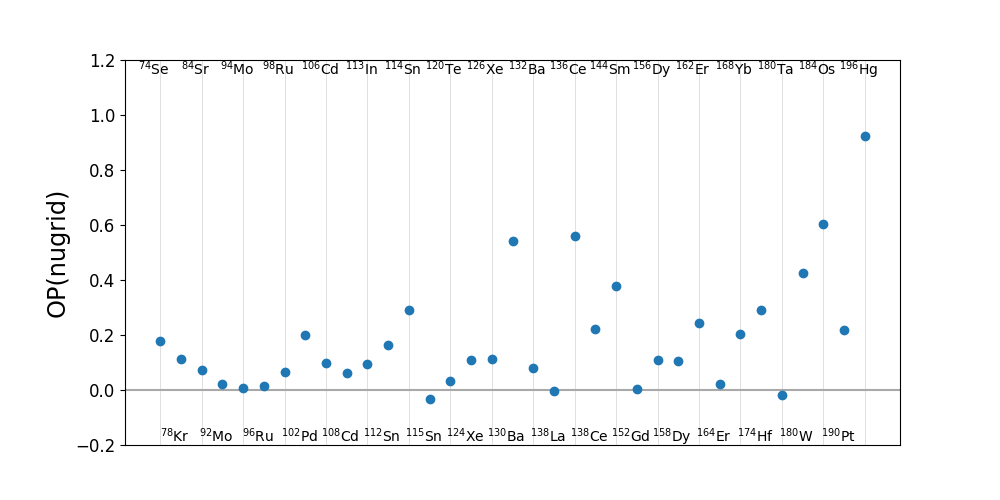

In [18]:
ifig=2; plt.close(ifig); plt.figure(ifig, figsize=(10,5))

xs = list(range(len(pnuclei)))
plt.scatter(xs, np.log10(allfacs), zorder=2)
plt.ylabel("OP(nugrid)", fontsize='xx-large')

plt.yticks(fontsize='large')
plt.xticks([])

ymin, ymax = -0.2, 1.2
yshift= (ymax-ymin)/50
for idx, isotope in enumerate(pnuclei, 1):

    ele, A = isotope.split('-')
    iso = fr'$^{{{A}}}\mathrm{{{ele}}}$'

    text_y = ymax-yshift*2 if idx % 2 == 1 else ymin+yshift*0.4
    plt.text(idx-1.3, text_y, iso, ha='center', fontsize='medium')
    
    if idx % 2 == 1:
        plt.axvline(idx-1, color='lightgrey', lw=0.5,zorder=1)
    
plt.axhline(0, color='darkgrey', zorder=1)
plt.ylim(ymin,ymax)

### Now we are going to pretend that this OP can just be multiplied and that's that (wrong obviously but this is zero order!)

In [15]:
cycle = 200000

nugrid_mass = star.get(cycle, 'mass')

def integrate2(isotope):
    
    nugrid_isotope = star.get(cycle, isotope)
    Xf =  np.trapz(nugrid_isotope, nugrid_mass) / nugrid_mass[-1]
    
    return Xf

final_nugrid = []
for spe in all_stable_species:
    final_nugrid.append(integrate2(spe))
    
    
final_nugrid = np.array(final_nugrid)
renorm_200000 = np.sum(final_nugrid)    
final_nugrid = final_nugrid / renorm_200000

print("Renormalized X")
print(f"Only stable meant sum(X) = {renorm_200000:.3e}")

 reading ['iso_massf']...100%Renormalized X
Only stable meant sum(X) = 9.723e-01


In [16]:
fake_yields = (res/res2) * final_nugrid

renorm_fake = np.sum(fake_yields)
fake_yields = fake_yields / renorm_fake

print("Renormalized X")
print(f"Applying OP meant sum(X) = {renorm_fake:.3e}")

Renormalized X
Applying OP meant sum(X) = 1.008e+00


(-9.0, 1.0)

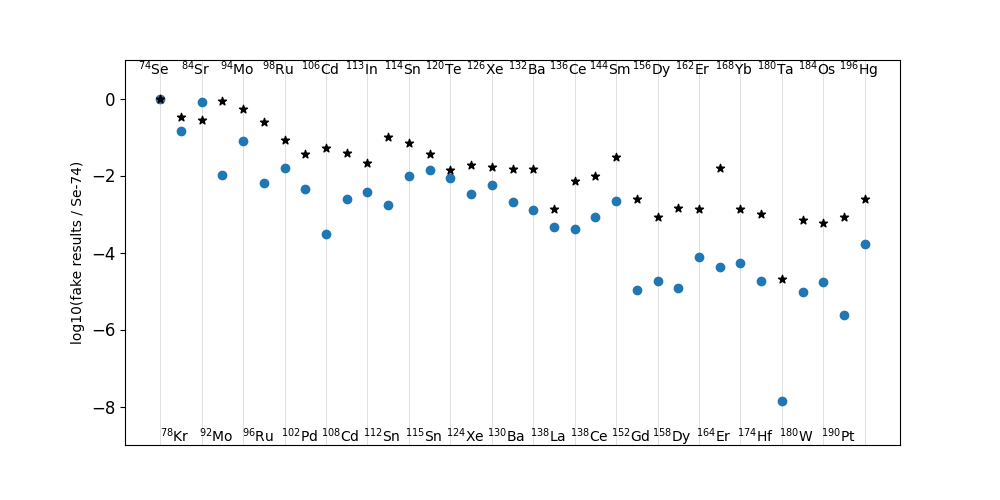

In [17]:
ifig=2; plt.close(ifig); plt.figure(ifig, figsize=(10,5))

xs = list(range(len(pnuclei)))
idxs = [all_stable_species.index(nuclei) for nuclei in pnuclei]
plt.scatter(xs, np.log10(fake_yields[idxs] / fake_yields[idxs][0]), zorder=2)
plt.scatter(xs, np.log10(get_sol_abu(pnuclei) / get_sol_abu("Se-74")), zorder=2, color='black', marker='*')
plt.ylabel("log10(fake results / Se-74)")

plt.yticks(fontsize='large')
plt.xticks([])

ymin, ymax = -9, 1
yshift= (ymax-ymin)/50
for idx, isotope in enumerate(pnuclei, 1):

    ele, A = isotope.split('-')
    iso = fr'$^{{{A}}}\mathrm{{{ele}}}$'

    text_y = ymax-yshift*2 if idx % 2 == 1 else ymin+yshift*0.4
    plt.text(idx-1.3, text_y, iso, ha='center', fontsize='medium')
    
    if idx % 2 == 1:
        plt.axvline(idx-1, color='lightgrey', lw=0.5,zorder=1)
    
#plt.axhline(0, color='darkgrey', zorder=1)
plt.ylim(ymin,ymax)